# Lab 7: Introduction to Implicit Neural Representations (INRs)
Welcome to week 7 of COMSM0159 Advanced Visual AI!

The goal of this labsheet is to provide an introduction to Implicit Neural Representations (INRs). By the end of this lab, you should be able to do the following:
1. Understand how INRs work and build a simple INR for image representation.
2. Experiment with your INR model for image deblurring.
3. Analyze the memory efficiency of INRs.


## Section 1: INR for Image Representation
Implicit Neural Representations (INRs) formulates a neural network (e.g., MLP) that can take the spatial co-ordinates of a signal and output the corresponding signal value. For 2D images, an INR learns an implicit function that takes pixel coordinates as input and returns the corresponding (R, G, B) values for that location. The memory required for such a representation scales with the complexity of the signal.

In this lab we will experiment with SIREN (Implicit Neural Activations with Periodic Activation Functions) as our main method. SIREN replaces the ReLU function in the MLP with a sine function as the activation function in the neural network layers, allowing it to model signals with fine details.

In [1]:
!pip install lpips
!pip install torchmetrics
!pip install --upgrade pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 16.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# some imports
import numpy as np
import torch
import torch.nn as nn
from scipy.ndimage import laplace, sobel
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import lpips
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 1 Initialize SIREN Layers
The sine layer is the basic building block of SIREN. SIREN is essentially a MLP (multi-layer perceptron) with sine activation. Note that SIREN is highly dependent on weights initialization to preserve the distribution of activations through the network. The authors propose the following initializations (check section 3.2 in the paper if you are interested):

* Weight is uniformly distributed such that
$$
w_i \sim U\left(-\frac{c}{\sqrt{n}}, \frac{c}{\sqrt{n}}\right)
$$
where c = 6.
    
* Initialize the first layer of the sine network with weights so that the sine function can be:
$$
\sin(\omega_0 \cdot W\mathbf{x} + b)
$$
where `omega_0` = 30.
  
To simplify, the key point here is that these initializations ensure the input to each sine activation is normally distributed with a standard deviation of 1, while the output of a SIREN is always arcsine distributed within the range of [-1, 1].

**Task 1:** Now complete the forward function below. Follow the equation provided below to complete the forward function. Try using [torch.sin()](https://pytorch.org/docs/stable/generated/torch.sin.html) as your sine activation function.
$$
\sin(\omega_0 \cdot W\mathbf{x} + b)
$$



In [4]:
class SineLayer(nn.Module):

    """ Linear layer followed by the sine activation

    If `is_first == True`, then it represents the first layer of the network.
    In this case, omega_0 is a frequency factor, which simply multiplies the activations before the nonlinearity.
    Note that it influences the initialization scheme.

    If `is_first == False`, then the weights will be divided by omega_0 so as to keep the magnitude of activations constant,
    but boost gradients to the weight matrix.
    """

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        # Initialize a linear layer with specified input and output features
        # 'bias' indicates whether to include a bias term
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    # initialize weights uniformly
    def init_weights(self):
        # diasble gradient calculation in initialization
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        # Task 1 TODO
        # 1. pass input through linear layer (self.linear layer performs the linear transformation on the input)

        # 2. scale the output of the linear transformation by the frequency factor

        # 3. apply sine activation

        return torch.sin(self.omega_0 * self.linear(input))


Now let's build up SIREN layers.


In [5]:
class Siren(nn.Module):
    """ SIREN architecture """

    def __init__(self, in_features, out_features, hidden_features=256, hidden_layers=3, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        # add the first layer
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        # append hidden layers
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))


        if outermost_linear:
            # add a final Linear layer
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad(): # weights intialization
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            # otherwise, add a SineLayer
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net) # sequential wrapper of SineLayer and Linear

    def forward(self, coords):
        # coords represents the 2D pixel coordinates
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

### Step 2 Data Preparation

Let's generate a grid of coordinates over a 2D space and reshape the output into a flattened format.

In [6]:
def get_mgrid(sidelen1,sidelen2, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''

    if sidelen1 >= sidelen2:
      # use sidelen1 steps to generate the grid
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)
      # crop it along one axis to fit sidelen2
      minor = int((sidelen1 - sidelen2)/2)
      mgrid = mgrid[:,minor:sidelen2 + minor]

    if sidelen1 < sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)

      minor = int((sidelen2 - sidelen1)/2)
      mgrid = mgrid[minor:sidelen1 + minor,:]

    # flatten the gird
    mgrid = mgrid.reshape(-1, dim)

    return mgrid

Make sure we convert the input to tensor and do normalization using transformations to the range [-1, 1], which corresponds to a mean of 0.5 and a standard deviation of 0.5.

In [7]:
def image_to_tensor(img):
    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img


In [8]:
# Image Fitting Dataloader
class ImageData(Dataset):
    def __init__(self, img):
        super().__init__()

        # convert the image to a tensor with transformations
        img = image_to_tensor(img)

        self.pixels = img.permute(1, 2, 0).reshape(-1, 3) # pixel values of the org img

        # create a grid of coordinates for the image
        self.coords = get_mgrid(img.shape[1], img.shape[2], 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

We are going to load and train an image from the [CelebFaces Attributes Dataset (CelebA)](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. CelebA is a large-scale face attributes dataset with more than 200K celebrity images.

To save you some time, you can directly download images from the celebDataset from the cloud below (a total of three celebrity face images are prepared for this lab: face1.jpg, face2.jpg, and face3.jpg for selection), or feel free to use any images you like.

**Task 2:** Visualize the input image

### Step 3 Training and Fitting an Image


In [9]:
# define differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

**Task 3:**

* Compute the gradient and the Laplacian of the output.

* Visualize the model output, gradient output and laplacian output.

*  What patterns do you notice in the gradient output compared to the model output? How do the edges detected by the Laplacian correlate with features in the model output?

Answer: able to explain where the model is sensitive to changes in input, and describe Laplacian (second derivative) can highlight areas of rapid intensity change - edges.

## Section 2: INR for Deblurring

Implicit neural representations can also be used for 2D image processing tasks like denoising, deblurring, inpainting, and super-resolution.

In this section, we will explore INR for non-blind deblurring.

### Step 1 Define Blurring Kernel

In [10]:

# Creating and Applying Blurring Kernels
# util: https://github.com/GaryMataev/DeepRED
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function (Creates a Gaussian blurring kernel)
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

def get_fft_h(im, blur_type):
    """Computes the Fourier transform of a blurring kernel
    """
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    ch, h, w = im.shape
    fft_h    =  np.zeros((h,w),)
    if blur_type=='uniform_blur':
        t        =  4 # 9//2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = 1/81
        fft_h    = np.fft.fft2(np.fft.fftshift(fft_h))
    else: # gauss_blur
        psf = fspecial_gauss(25, 1.6)
        t = 12 # 25 // 2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = psf
        fft_h    =  np.fft.fft2(np.fft.fftshift(fft_h))
    return fft_h

def blur(im, blur_type):
    """Apply blur kernel to the input image
    """
    fft_h = get_fft_h(im, blur_type)
    imout = np.zeros_like(im)
    for i in range(im.shape[0]):
        im_f    =  np.fft.fft2(im[i, :, :])
        z_f     =  fft_h*im_f # .* of matlab
        z       =  np.real(np.fft.ifft2(z_f))
        imout[i, :, :] = z
    return imout


# - the inverse function H -
def get_h(n_ch, blur_type, use_fourier, dtype):
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    if not use_fourier:
        return Downsampler(n_ch, 1, blur_type, preserve_size=True).type(dtype)
    return lambda im: torch_blur(im, blur_type, dtype)


def torch_blur(im, blur_type, dtype):
  # blur an image tensor
    fft_h = get_fft_h(torch_to_np(im), blur_type)
    fft_h_torch = torch.unsqueeze(torch.from_numpy(np.real(fft_h)).type(dtype), 2)
    fft_h_torch = torch.cat([fft_h_torch, fft_h_torch], 2)
    z = []
    for i in range(im.shape[1]):
        im_torch = torch.unsqueeze(im[0, i, :, :], 2)
        im_torch = torch.cat([im_torch, im_torch], 2)
        im_f    =  torch.fft(im_torch, 2)
        z_f     =  torch.mul(torch.unsqueeze(fft_h_torch, 0), torch.unsqueeze(im_f, 0)) # .* of matlab
        z.append(torch.ifft(z_f, 2))
    z = torch.cat(z, 0)
    return torch.unsqueeze(z[:, :, :, 0], 0)


### Step 2 Data Preparation

In [11]:

class Downsampler(nn.Module):
    """
        Resampling filters
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    """

    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None,
                 preserve_size=False, pad_type='reflection', transpose_conv=False):
        super(Downsampler, self).__init__()

        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1 / 2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1. / np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type == 'uniform_blur':
            kernel_width = 9
            kernel_type_ = 'uniform'
            pad_type = 'circular'

        elif kernel_type == 'gauss_blur':
            kernel_width = 25
            sigma = 1.6
            kernel_type_ = 'gauss'
            pad_type = 'circular'

        elif kernel_type in {'lanczos', 'gauss', 'box'}:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'

        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        if transpose_conv:
            if self.kernel.shape[0] % 2 == 1:
                pad = int((self.kernel.shape[0] - 1) // 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) // 2.)
            downsampler = nn.ConvTranspose2d(n_planes, n_planes, kernel_size=self.kernel.shape,
                                             stride=factor, padding=pad)
        else:
            downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch

        self.downsampler_ = downsampler

        if preserve_size:
            if pad_type=='circular':
                self.padding = lambda torch_in: pad_circular(torch_in, kernel_width // 2)
            elif pad_type=='reflection':
                if self.kernel.shape[0] % 2 == 1:
                    pad = int((self.kernel.shape[0] - 1) // 2.)
                else:
                    pad = int((self.kernel.shape[0] - factor) // 2.)
                self.padding = nn.ReplicationPad2d(pad)
            else:
                assert False, "pad_type have only circular or reflection options"
        self.preserve_size = preserve_size

    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x = input
        self.x = x
        return self.downsampler_(x)


def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box', 'uniform', 'blur']

    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box':
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])

    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1. / (kernel_width * kernel_width)

    elif kernel_type == 'gauss':
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        return fspecial_gauss(kernel_width, sigma)

    elif kernel_type == 'uniform':
        kernel = np.ones([kernel_width, kernel_width])

    elif kernel_type == 'lanczos':
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):#print metrics

                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor
                    dj = abs(j + 0.5 - center) / factor
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor

                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)

                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                kernel[i - 1][j - 1] = val
    else:
        assert False, 'wrong method name'
    kernel /= kernel.sum()
    return kernel


def pad_circular(x, pad):
    """
    :param x: pytorch tensor of shape: [batch, ch, h, w]
    :param pad: uint
    :return:
    """
    x = torch.cat([x, x[:, :, 0:pad]], dim=2)
    x = torch.cat([x, x[:, :, :, 0:pad]], dim=3)
    x = torch.cat([x[:, :, -2*pad:-pad], x], dim=2)
    x = torch.cat([x[:, :, :, -2*pad:-pad], x], dim=3)
    return x


In [12]:
blur_type = 'box'
downsampler = Downsampler(n_planes=3, factor=16, kernel_type=blur_type, phase=0.5, kernel_width=16, preserve_size=True).to(device)

### Step 3 Training and Deblurring

**Task 4:** Visualize output

In [13]:
def visualize_images_at_the_end(model_output, title1="Siren for Super Res output", title2="Original Hi Res img", title3="Low Res Siren Input img", save_path=None):
  """Visualizes two images: model_output and model_output_downsampled.

  Args:
    model_output: The first image tensor, assumed to be in shape (1, 3, height, width).
    model_output_downsampled: The second image tensor, assumed to be in shape (1, 3, height_lr, width_lr).
    title1: Title for the first image plot. Defaults to "model_output".
    title2: Title for the second image plot. Defaults to "model_output_downsampled".
  """

  # Process and display model_output
  model_output_image = model_output.detach().cpu().squeeze(0).permute(1, 2, 0)
  model_output_image = (model_output_image + 1) / 2
  model_output_image = model_output_image.clamp(0, 1)



  plt.figure(figsize=(15, 15))  # Adjust figure size if needed
  plt.subplot(3, 1, 1)  # Create a subplot for the second image
  plt.imshow(np.array(image_hr))
  plt.title(title2)
  plt.axis('off')

  plt.subplot(3, 1, 2)  # Create a subplot for the first image
  plt.imshow(model_output_image)
  plt.title(title1)
  plt.axis('off')


  plt.subplot(3, 1, 3)  # Create a subplot for the second image
  plt.imshow(np.array(image_lr))
  plt.title(title3)
  plt.axis('off')

  if save_path:
    plt.savefig(save_path, format='png', bbox_inches='tight')
    print(f"Plot saved as: {save_path}")


  plt.show()

In [14]:
downsampler_x2 = Downsampler(n_planes=3, factor=2, kernel_type="box", phase=0.5, kernel_width=2, preserve_size=True).to(device)

def process_image_with_downsampler(image_lr, downsampler, device, height, width, boolUpsample=True):
    # Step 1: Convert PIL image to PyTorch tensor
    image_lr_np = np.array(image_lr).astype(np.float32) / 255.0  # Normalize to [0, 1]
    image_lr_tensor = torch.tensor(image_lr_np).permute(2, 0, 1).unsqueeze(0).to(device)  # Shape: (1, 3, H, W)

    # Step 2: Apply downsampling
    image_downsampled = downsampler(image_lr_tensor)

    if boolUpsample:
        image_upsampled = F.interpolate(image_downsampled, size=(height, width), mode='nearest')
        image_result = image_upsampled.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, 3)
    else:
      image_result = image_downsampled.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Shape: (H, W, 3)

    image_result = (image_result * 255.0).clip(0, 255).astype(np.uint8)  # Convert back to [0, 255]
    image_pil = Image.fromarray(image_result)

    return image_pil

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Helper function to resize the image
def resize_image(img_pil, target_size):
    return img_pil.resize(target_size, Image.NEAREST)


#img_index = '0465'
#img_index = '0170'
#img_index = '0025'
img_index = '0185'
#img_index = '0745'
out_path = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/SIREN_OUTPUT_x16/' + img_index + '/'
fname_hr = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIV2K_train_HR/' + img_index + '.png'
fname_lr = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIV2K_train_LR_x8/' + img_index + 'x8.png'

image_hr = Image.open(fname_hr)


image_lr = Image.open(fname_lr)

# Get width and height
width, height = image_hr.size


image_lr_visualise_x8 = resize_image(image_lr, (width, height))

image_lr = process_image_with_downsampler(image_lr, downsampler_x2, device, height, width)



width_lr, height_lr = image_lr.size
print(f"Width: {width}, Height: {height}")
print(f"Width_lr: {width_lr}, Height_lr: {height_lr}")


Width: 2040, Height: 1152
Width_lr: 2040, Height_lr: 1152


In [18]:
image_lr_test_bic = Image.open(fname_lr)

image_lr_test_bic = process_image_with_downsampler(image_lr_test_bic, downsampler_x2, device, height, width, boolUpsample=False)

print(image_lr_test_bic.size)

# Helper function to resize the image
def resize_image_bicub_test(img_pil, target_size):
    return img_pil.resize(target_size, Image.BICUBIC)

image_lr_test_bic = resize_image_bicub_test(image_lr_test_bic, (width, height))

print(compare_psnr(np.array(image_lr_test_bic), np.array(image_hr)))

(127, 72)
23.174855599472927


(-0.5, 2039.5, 1151.5, -0.5)

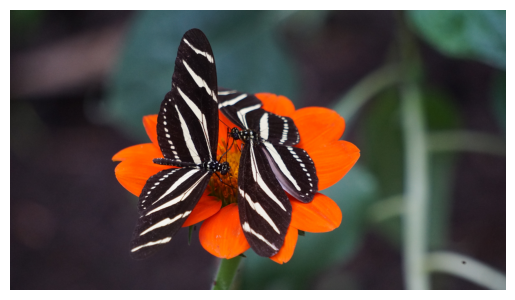

In [19]:
plt.imshow(np.array(image_hr))
plt.axis('off')

(-0.5, 2039.5, 1151.5, -0.5)

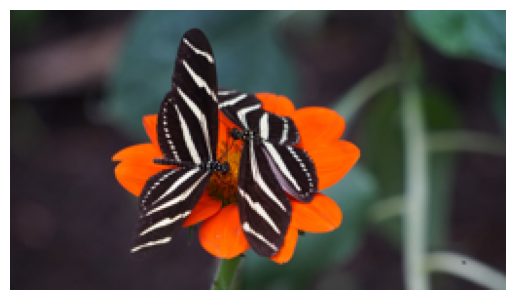

In [20]:
plt.imshow(np.array(image_lr_visualise_x8))
plt.axis('off')

(-0.5, 2039.5, 1151.5, -0.5)

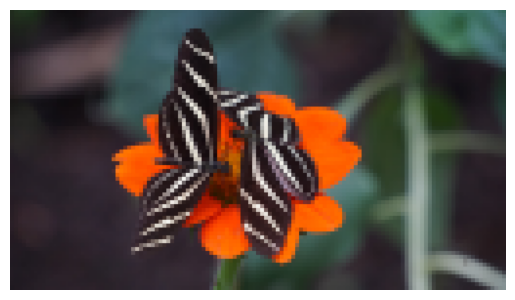

In [21]:
plt.imshow(np.array(image_lr))
plt.axis('off')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 167MB/s]
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't ha

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Step 0, Total loss 0.333232
0.0001
Step: 0 PSNR_LR: 10.7931386353312 PSNR_HR: 10.556263304967676 SSIM: 0.5925031304359436 LPIPS: 0.7386988401412964


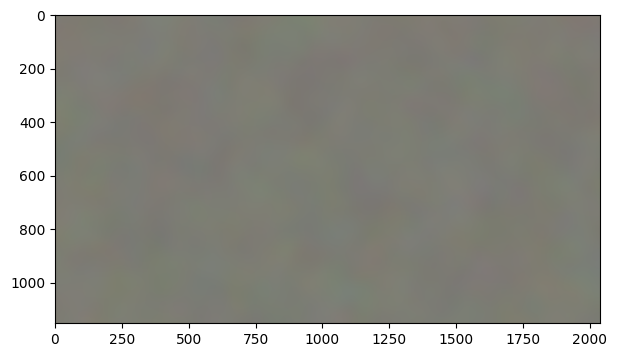

Step 200, Total loss 0.000368
0.0001
Step: 200 PSNR_LR: 40.36033359017885 PSNR_HR: 26.378561846789076 SSIM: 0.8711624145507812 LPIPS: 0.3549950122833252


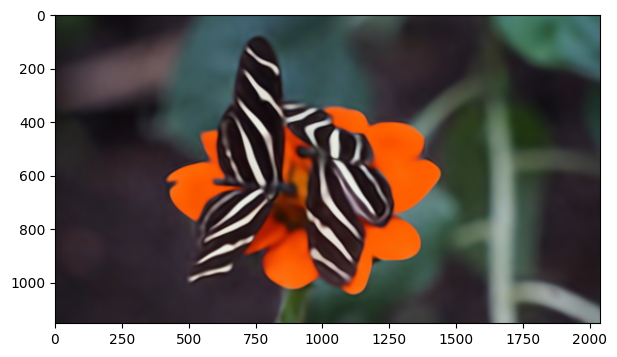

Step 400, Total loss 0.000095
0.0001
Step: 400 PSNR_LR: 46.249284434969255 PSNR_HR: 26.7185651969436 SSIM: 0.875668466091156 LPIPS: 0.34601449966430664


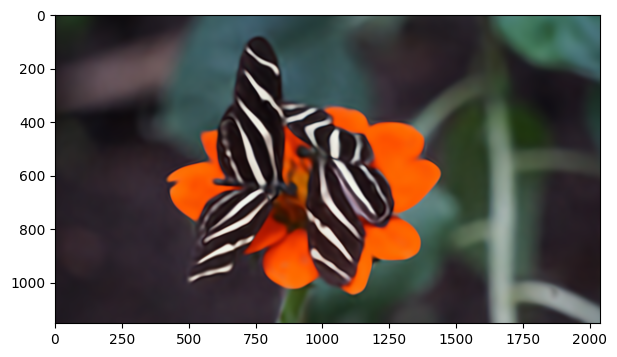

Step 600, Total loss 0.000046
0.0001
Step: 600 PSNR_LR: 49.40953411566544 PSNR_HR: 26.744586160493494 SSIM: 0.8739067316055298 LPIPS: 0.3437497615814209


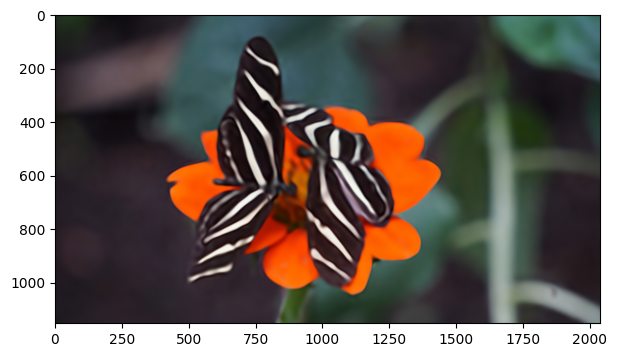

Step 800, Total loss 0.000035
0.0001
Step: 800 PSNR_LR: 50.532328284558645 PSNR_HR: 26.744768693035308 SSIM: 0.8757028579711914 LPIPS: 0.3428022861480713


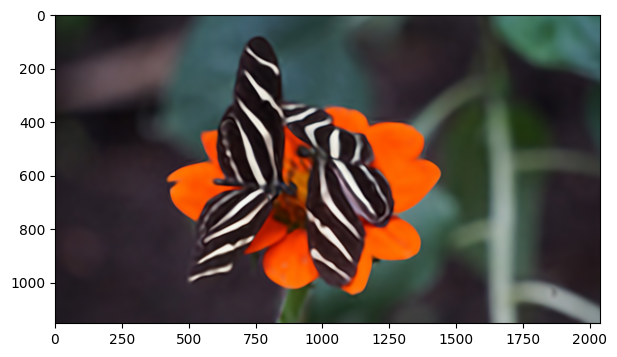

Step 1000, Total loss 0.000021
0.0001
Step: 1000 PSNR_LR: 52.827985373183836 PSNR_HR: 26.739565813937972 SSIM: 0.8671836256980896 LPIPS: 0.34245049953460693


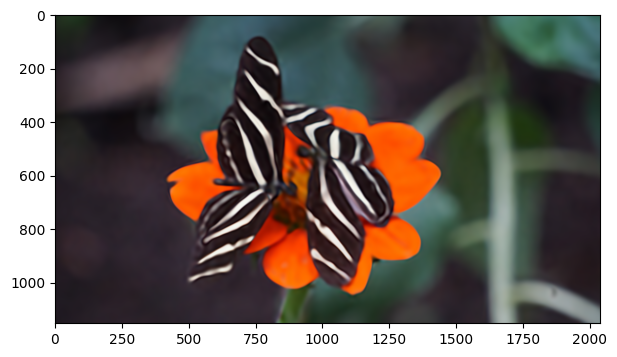

Step 1200, Total loss 0.000011
7.500000000000001e-05
Step: 1200 PSNR_LR: 55.744066008957454 PSNR_HR: 26.74339409318533 SSIM: 0.8754240870475769 LPIPS: 0.3420052230358124


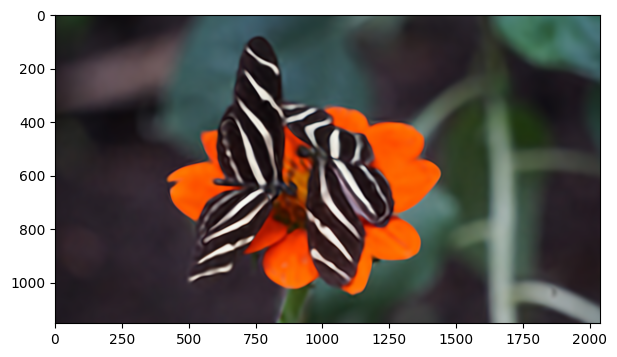

KeyboardInterrupt: 

In [22]:
celeb_lr = ImageData(image_lr)
dataset_lr = DataLoader(celeb_lr, batch_size=1, pin_memory=True, num_workers=0)

celeb_hr = ImageData(image_hr)
dataset_hr = DataLoader(celeb_hr, batch_size=1, pin_memory=True, num_workers=0)

lpips_loss_fn = lpips.LPIPS(net='alex').to(device)
# create a siren model ready for deblurring
img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=6, outermost_linear=True)
img_siren.to(device)


total_steps = 2000
steps_til_summary = 200

#optim = torch.optim.Adam(lr=0.0001, params=img_siren.parameters(), weight_decay=1e-5)
optim = torch.optim.Adam(lr=0.0001, params=img_siren.parameters())

# Initialize learning rate scheduler

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    mode='min',     # Because we're minimizing the loss
    factor=0.75,     # Factor by which the learning rate will be reduced
    patience=100,   # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True    # Prints a message when the learning rate is reduced
)


model_input, ground_truth = next(iter(dataset_lr))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

hr_gt_img, hr_ground_truth = next(iter(dataset_hr))
hr_gt_img, hr_ground_truth = hr_gt_img.cuda(), hr_ground_truth.cuda()

#psnr
input_image_lr_np = np.array(image_lr).astype(np.float32) / 255.0
input_image_hr_np = np.array(image_hr).astype(np.float32) / 255.0

psnr_history = []

for step in range(total_steps):
    model_output, coords = img_siren(model_input)

    model_output_img = model_output.view(1, height, width, 3).permute(0, 3, 1, 2)  # Reshape to image format
    model_output_downsampled = downsampler(model_output_img)  # Apply downsampling
    model_output_upsampled = F.interpolate(model_output_downsampled, size=(height, width), mode='nearest')  # Upsample
    model_outputnew = model_output_upsampled.permute(0, 2, 3, 1).view(1, -1, 3)  # Reshape back to original format

    loss = ((model_outputnew - ground_truth)**2).mean()

    if (not step % steps_til_summary) or step==total_steps-1:
        print("Step %d, Total loss %0.6f" % (step, loss))
        print(scheduler.optimizer.param_groups[0]['lr'])


        # Prepare ground truth image in correct format
        hr_ground_truth_img = hr_ground_truth.view(1, height, width, 3).permute(0, 3, 1, 2).to(device)
        # Ensure images are on the same device
        model_output_img = model_output_img.to(device)
        # Scale images to [0, 1] for SSIM
        model_output_img_01 = (model_output_img + 1) / 2
        hr_ground_truth_img_01 = (hr_ground_truth_img + 1) / 2
        # Compute SSIM
        ssim_value = ssim(model_output_img_01, hr_ground_truth_img_01, data_range=1.0, size_average=True)
        # Compute LPIPS
        lpips_value = lpips_loss_fn(model_output_img, hr_ground_truth_img)

        # 2. Get the output image (high-resolution) as a NumPy array:
        output_image_np = model_output_img_01.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

        output_image_lr_np = model_output_upsampled.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
        output_image_lr_np = (output_image_lr_np + 1) / 2  # Scale to [0, 1]

        psnr_LR = compare_psnr(input_image_lr_np, output_image_lr_np)
        psnr_HR = compare_psnr(input_image_hr_np, output_image_np)

        print('Step:', step, 'PSNR_LR:', psnr_LR, 'PSNR_HR:', psnr_HR,
              'SSIM:', ssim_value.item(), 'LPIPS:', lpips_value.item())

        # History
        psnr_history.append([step, psnr_LR, psnr_HR, loss.item(), ssim_value.item(), lpips_value.item()])

        model_output = (model_output + 1) / 2  # Convert output to [0, 1]
        model_output = model_output.clamp(0, 1)  # Clip
        output = model_output.cpu().view(height, width, 3).detach().numpy()

        fig, axes = plt.subplots(1, 1, figsize=(12, 4))
        axes.imshow(output)
        plt.show()


    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step(loss)



Plot saved as: /content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/SIREN_OUTPUT_x16/0185/output_image_grid_0185.png


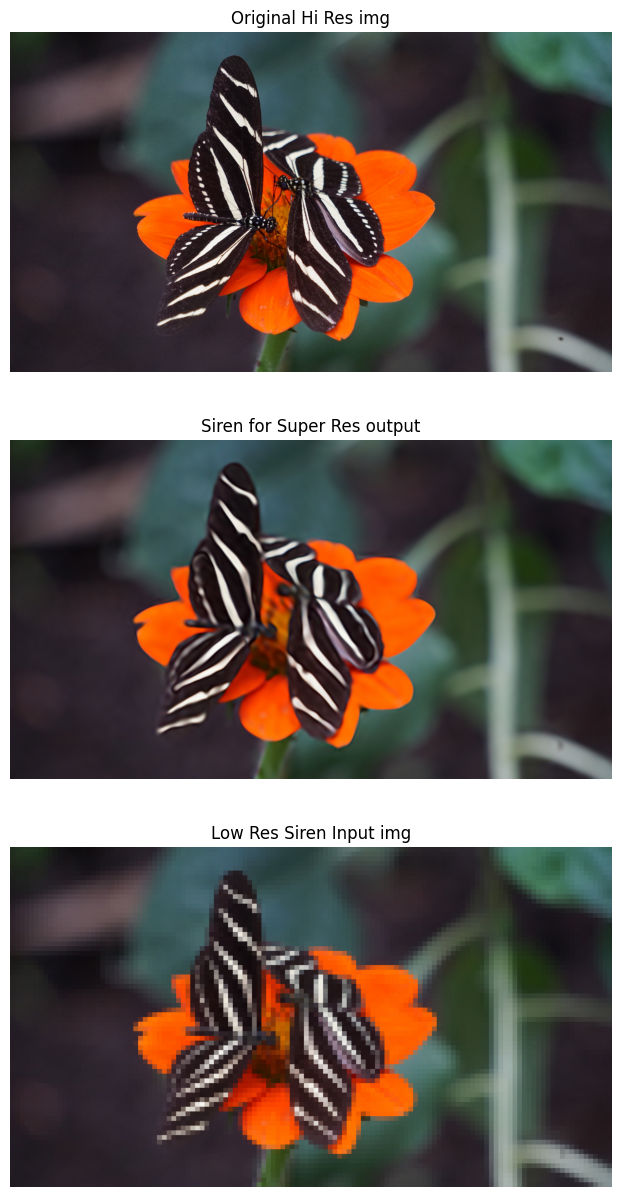

In [23]:
model_output_img_01 = (model_output_img + 1) / 2

sv_path = out_path + 'output_image_' + img_index + '.png'

save_image(model_output_img_01, sv_path)

sv_path = out_path + 'output_image_grid_' + img_index + '.png'
visualize_images_at_the_end(model_output_img, save_path=sv_path)

PSNR History (Iteration-wise):
Step 0 - PSNR_LR: 10.793, PSNR_HR: 10.556, loss: 0.333232 ssim: 0.5925031304359436 lpips: 0.7386988401412964
Step 200 - PSNR_LR: 40.360, PSNR_HR: 26.379, loss: 0.000368 ssim: 0.8711624145507812 lpips: 0.3549950122833252
Step 400 - PSNR_LR: 46.249, PSNR_HR: 26.719, loss: 0.000095 ssim: 0.875668466091156 lpips: 0.34601449966430664
Step 600 - PSNR_LR: 49.410, PSNR_HR: 26.745, loss: 0.000046 ssim: 0.8739067316055298 lpips: 0.3437497615814209
Step 800 - PSNR_LR: 50.532, PSNR_HR: 26.745, loss: 0.000035 ssim: 0.8757028579711914 lpips: 0.3428022861480713
Step 1000 - PSNR_LR: 52.828, PSNR_HR: 26.740, loss: 0.000021 ssim: 0.8671836256980896 lpips: 0.34245049953460693
Step 1200 - PSNR_LR: 55.744, PSNR_HR: 26.743, loss: 0.000011 ssim: 0.8754240870475769 lpips: 0.3420052230358124
Plot saved as: /content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/SIREN_OUTPUT_x16/0185/plot_0185.png


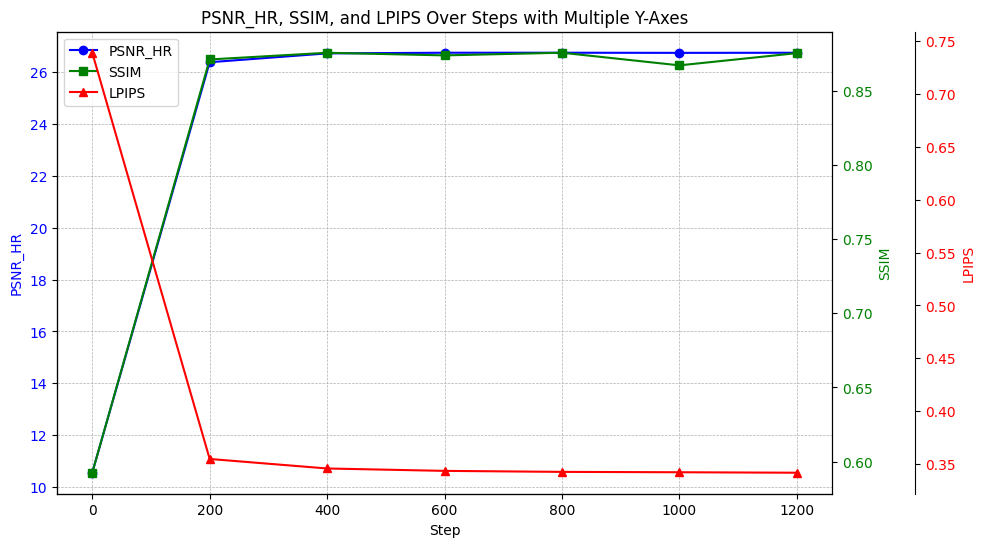

In [24]:
# lr = 0.0001 * 0.8
# weight decay = 0.00001
print("PSNR History (Iteration-wise):")

steps = []
psnr_hrs = []
ssims = []
lpipss = []

for idx, (step, psnr_LR, psnr_HR, loss, ssim, lpips) in enumerate(psnr_history):
    steps.append(step)
    psnr_hrs.append(psnr_HR)
    ssims.append(ssim)
    lpipss.append(lpips)
    print(f"Step {step} - PSNR_LR: {psnr_LR:.3f}, PSNR_HR: {psnr_HR:.3f}, loss: {loss:.6f}", "ssim:", ssim, "lpips:", lpips)
    save_path = out_path + 'eval_qual_metrics_' + img_index + '.txt'
    with open(save_path, "a") as file:
        file.write(f"Step {step} - PSNR_LR: {psnr_LR:.3f}, PSNR_HR: {psnr_HR:.3f}, loss: {loss:.6f}, ssim:, {ssim:.6f}, lpips:, {lpips:.6f}, \n")

import matplotlib.pyplot as plt

# Sample data (replace with your actual data)

# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PSNR_HR on the primary y-axis
ax1.plot(steps, psnr_hrs, 'b-o', label='PSNR_HR')
ax1.set_xlabel('Step')
ax1.set_ylabel('PSNR_HR', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for SSIM
ax2 = ax1.twinx()
ax2.plot(steps, ssims, 'g-s', label='SSIM')
ax2.set_ylabel('SSIM', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create a tertiary y-axis for LPIPS
# Offset the spine to make room for the third axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(steps, lpipss, 'r-^', label='LPIPS')
ax3.set_ylabel('LPIPS', color='r')
ax3.tick_params(axis='y', labelcolor='r')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

# Add a grid for better readability
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Set the title
plt.title('PSNR_HR, SSIM, and LPIPS Over Steps with Multiple Y-Axes')
save_path = out_path + 'plot_' + img_index + '.png'

plt.savefig(save_path, format='png', bbox_inches='tight')
print(f"Plot saved as: {save_path}")

# Show the plot0465
plt.show()


In [20]:
def resize_image_bicubic(img_pil, target_size):
    return img_pil.resize(target_size, Image.BICUBIC)

#image_lr_test = Image.open(fname_lr)
input_image_hr_np = np.array(image_hr).astype(np.float32) / 255.0
image_lr_test = resize_image_bicubic(image_lr, (width, height))
print(image_lr_test.size)
image_lr_test.save(out_path + '_bicubic_' + img_index + '.png')

image_lr_test = np.array(image_lr_test)
image_lr_test = np.array(image_lr_test)
image_lr_test = np.array(image_lr_test).astype(np.float32) / 255.0  # Normalize to [0, 1]

# Compute PSNR
psnr_value = compare_psnr(input_image_hr_np, image_lr_test)

save_path = out_path + 'eval_qual_metrics_' + img_index + '.txt'

# Save the result to a text file
with open(save_path, "a") as file:  # "a" mode appends to the file if it exists
    file.write(f"BICUBIC: {psnr_value:.6f}\n")

# Optional: Print to console as well
print('BICUBIC:', psnr_value)

(2040, 1152)
BICUBIC: 21.652067097253102
